In [1]:
# INSTRUCTIONS: 
# Cell --> Run All
# Remember you can only guess classes 3-9!
# It helps to use fullscreen to make your guesses 
# When you are done - copy your confusion matrix to the slides!

# Feel free to modify these params if you want to see more / have more time 
train_per_class = 6
num_validation_images = 25


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import argparse
import os
import sys
import time
import pickle
import numpy as np
import pandas as pd
from six.moves import xrange  
import tensorflow as tf
import gdal
from matplotlib import pyplot as plt
import geotiling as gt

In [6]:
df_annos = pd.read_csv("../data/annos_csv/state24_paths_density_labels_13k_Feb10.csv", index_col=0)
img_path = "/home/timhu/all_tif"

image_composite = gt.ImageComposite("../data/lspop2011.tif", 1)
image_composite = gt.ImageComposite("../data/F182011.v4c_web.stable_lights.avg_vis.tif", 1)

#degreees, lat, long 

print(image_composite)


In [7]:
# def load_tif_from_file(file, label):
#     img_file = gdal.Open(file)
    
#     width, height = img_file.RasterXSize, img_file.RasterYSize
#     img_data = img_file.ReadAsArray(0, 0, width, height) # returns np array of shape (C, H, W)
#     img_data = np.moveaxis(img_data, 0, -1)
    
#     return img_data, label

def load_tif_from_file(file, label, W, H):
    img_file = gdal.Open(file)
    width, height = img_file.RasterXSize, img_file.RasterYSize
    if W > width:
        raise Exception("Requested width exceeds tif width.")
    if H > height:
        raise Exception("Requested height exceeds tif height.")  
    # returns np array of shape (C, H, W)
    img_data = img_file.ReadAsArray((width - W)//2, (height - H)//2, W, H) 
    img_data = np.moveaxis(img_data, 0, -1)
    return img_data, label

def curr_image_l8(class_val, i, col_idx):
    #print(class_val)
    #print(df_annos.loc[df_annos['pop_density_class'] == class_val])
    if (class_val is 9):
        tiff_path = df_annos.loc[df_annos['pop_density_class'] == class_val].values[i*3][col_idx]
    else:
        tiff_path = df_annos.loc[df_annos['pop_density_class'] == class_val].values[i*10][col_idx]
    #print(tiff_path)
    img_data, label = load_tif_from_file("/home/timhu/all_tif/"+str(tiff_path), 0, 150, 150)
    img_tif = gdal.Open("/home/timhu/all_tif/"+str(tiff_path))
    return img_data

def curr_image_s1(class_val, i, col_idx):
    #print(class_val)
    #print(df_annos.loc[df_annos['pop_density_class'] == class_val])
    if (class_val is 9):
        tiff_path = df_annos.loc[df_annos['pop_density_class'] == class_val].values[i*3][col_idx]
    else:
        tiff_path = df_annos.loc[df_annos['pop_density_class'] == class_val].values[i*10][col_idx]
    #print(tiff_path)
    img_data, label = load_tif_from_file("/home/timhu/all_tif/"+str(tiff_path), 0, 450, 450)
    img_tif = gdal.Open("/home/timhu/all_tif/"+str(tiff_path))
    return img_data


def nightlight_curr_image(class_val, i, km_side):
    lat, lon = 26.978193, 75.827624
    if (class_val is 9):
        lat = df_annos.loc[df_annos['pop_density_class'] == class_val].values[i*3][6]
        lon = df_annos.loc[df_annos['pop_density_class'] == class_val].values[i*3][5]
    else:
        lat = df_annos.loc[df_annos['pop_density_class'] == class_val].values[i*10][6]
        lon = df_annos.loc[df_annos['pop_density_class'] == class_val].values[i*10][5]
        
    col, row = image_composite.geoprops.lonlat2colrow(lon, lat)
#     print(image_composite.geoprops.xOrigin)
#     print(col, row)
    #FACT: true same size would be 4.5 by 4.5 pixels since each pixel is about a km2
    x = image_composite.gdal_dataset.ReadAsArray(col - int(km_side/2), row - int(km_side/2), km_side, km_side)
    np.place(x, x == -2147483647, 0)
    #print(x)
    return x

In [8]:
# x = image_composite.gdal_dataset.ReadAsArray(5000, 1000, 10000, 10000)
# plt.imshow(x, cmap='gray')

In [9]:
# print(x.shape)

In [10]:
def show_training_images(class_to_show, cols, img_type):
    if img_type == "L": #Landscan
        classes = 1
        fig = plt.figure(figsize=(18, 6))
        #for class_val in range(0,classes):
        for i in range(0,cols):
            ax1 = fig.add_subplot(classes,cols,i+1)
            ax1.imshow(curr_image_l8(class_to_show, i+1, 12))
        plt.show()
    if img_type == "S": #Sentinel
        classes = 1
        fig = plt.figure(figsize=(18, 6))
        #for class_val in range(0,classes):
        for i in range(0,cols):
            ax1 = fig.add_subplot(classes,cols,i+1)
            ax1.imshow(curr_image_s1(class_to_show, i+1, 13))
        plt.show()
    if img_type == "N": #Nightlights
        classes = 1
        fig = plt.figure(figsize=(18, 6))
        #for class_val in range(0,classes):
        for i in range(0,cols):
            ax1 = fig.add_subplot(classes,cols,i+1)
            ax1.imshow(nightlight_curr_image(class_to_show, i+1, 30), cmap='gray')
        classes = 1
        fig = plt.figure(figsize=(18, 6))
        #for class_val in range(0,classes):
        for i in range(0,cols):
            ax1 = fig.add_subplot(classes,cols,i+1)
            ax1.imshow(nightlight_curr_image(class_to_show, i+1, 5), cmap='gray')
        

In [11]:
df_annos = pd.read_csv("../data/annos_csv/state24_paths_density_labels_13k_Feb10.csv", index_col=0)

============== Class 3 ===============


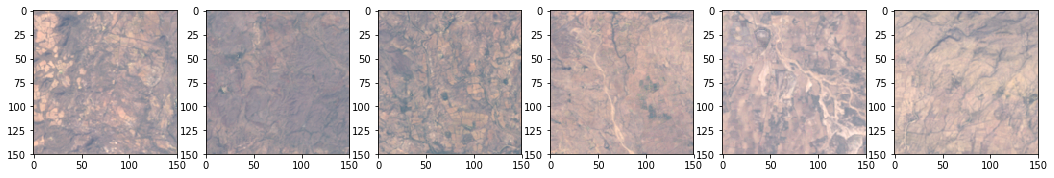

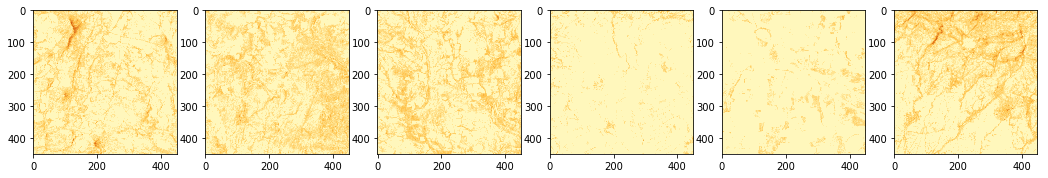

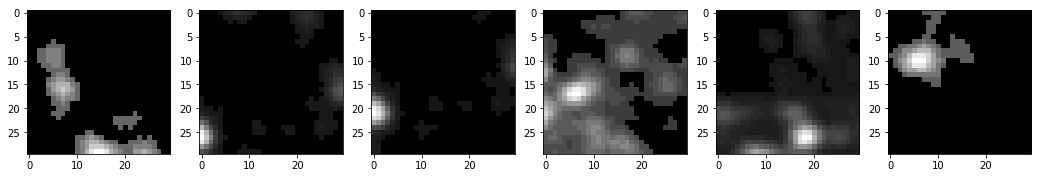

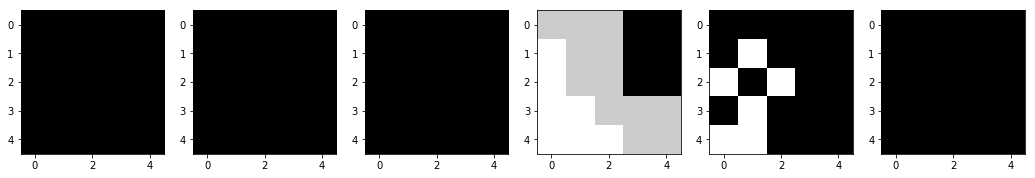

In [12]:
print("============== Class 3 ===============")
show_training_images(3, train_per_class, "L")
show_training_images(3, train_per_class, "S")
show_training_images(3, train_per_class, "N")

============== Class 4 ===============


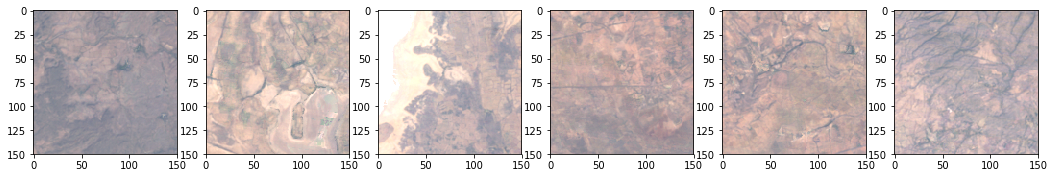

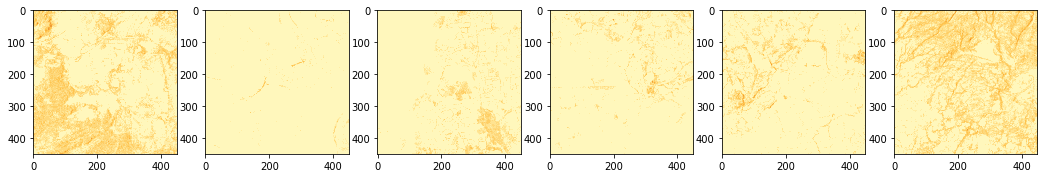

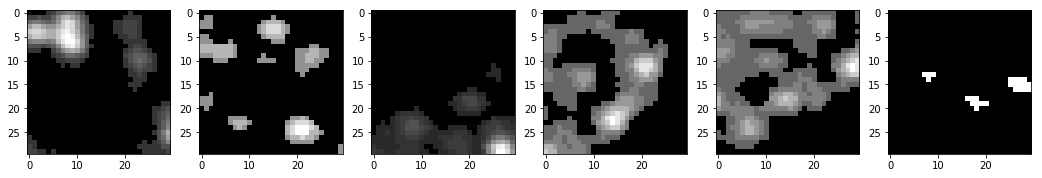

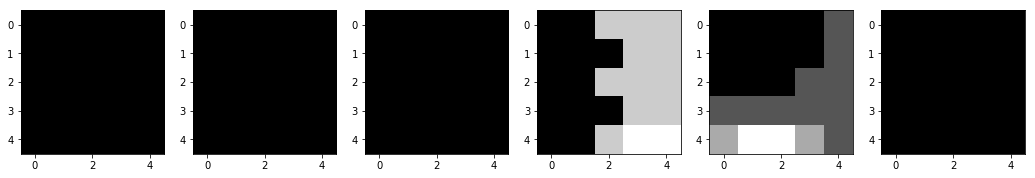

In [13]:
print("============== Class 4 ===============")
show_training_images(4, train_per_class, "L")
show_training_images(4, train_per_class, "S")
show_training_images(4, train_per_class, "N")

============== Class 5 ===============


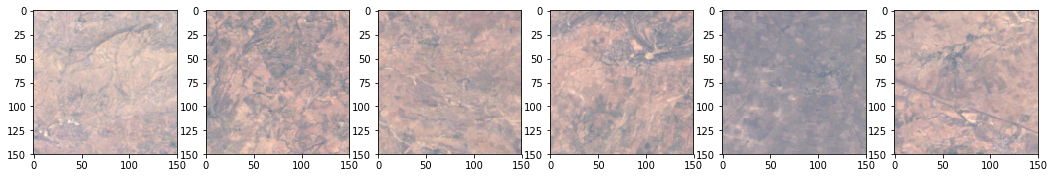

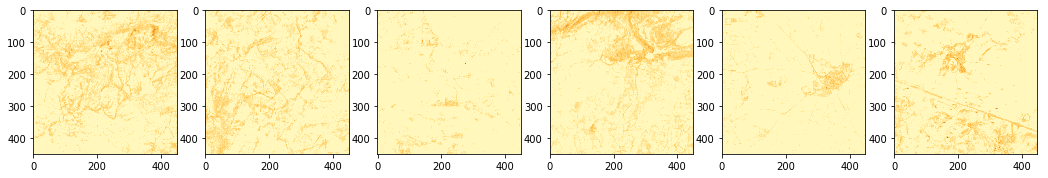

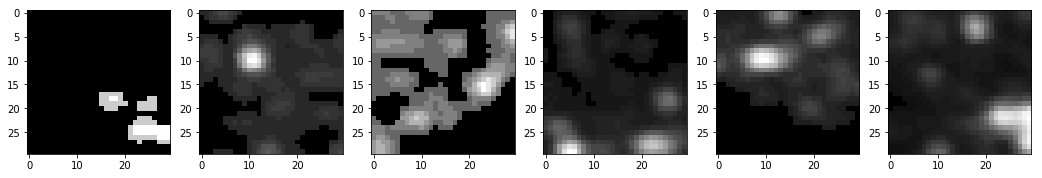

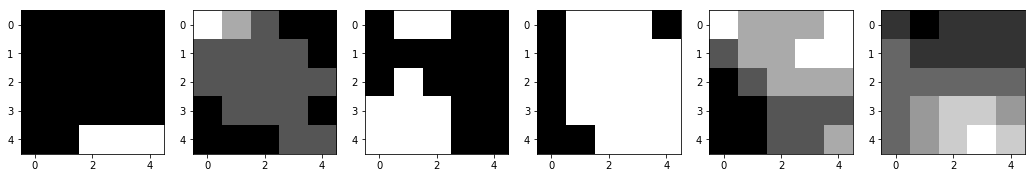

In [14]:
print("============== Class 5 ===============")
show_training_images(5, train_per_class, "L")
show_training_images(5, train_per_class, "S")
show_training_images(5, train_per_class, "N")

============== Class 6 ===============


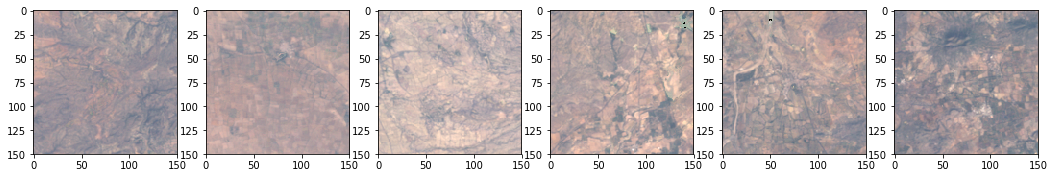

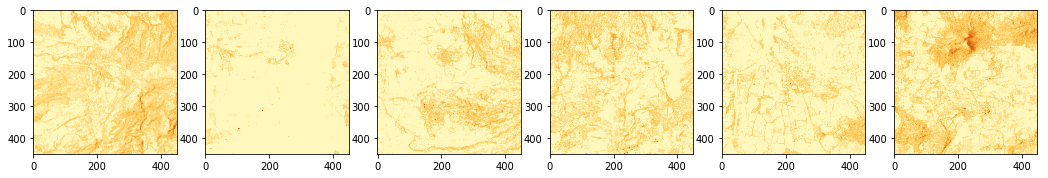

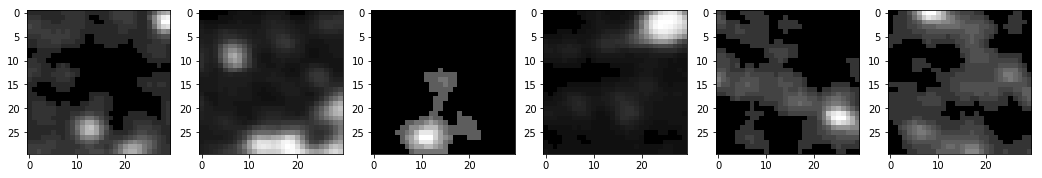

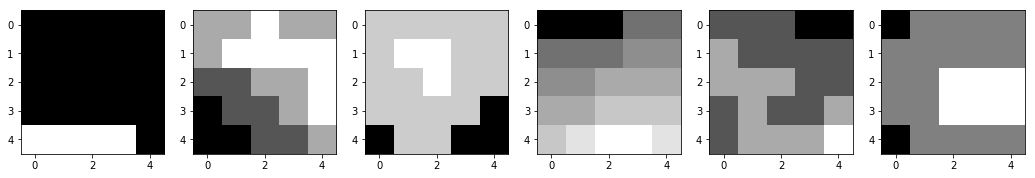

In [15]:
print("============== Class 6 ===============")
show_training_images(6, train_per_class, "L")
show_training_images(6, train_per_class, "S")
show_training_images(6, train_per_class, "N")

============== Class 7 ===============


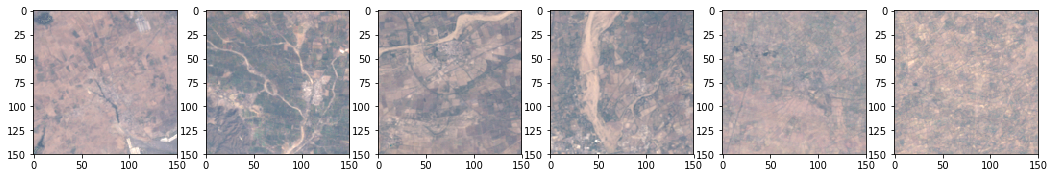

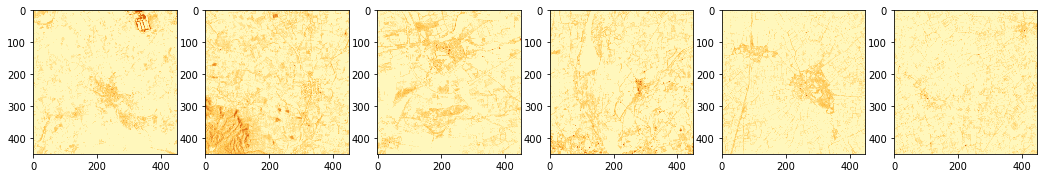

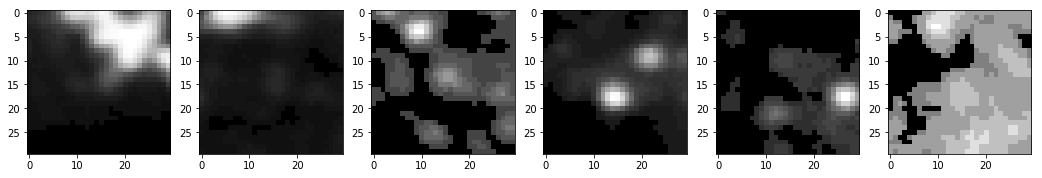

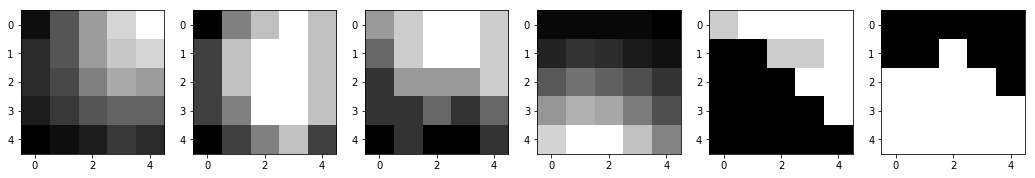

In [16]:
print("============== Class 7 ===============")
show_training_images(7, train_per_class, "L")
show_training_images(7, train_per_class, "S")
show_training_images(7, train_per_class, "N")

============== Class 8 ===============


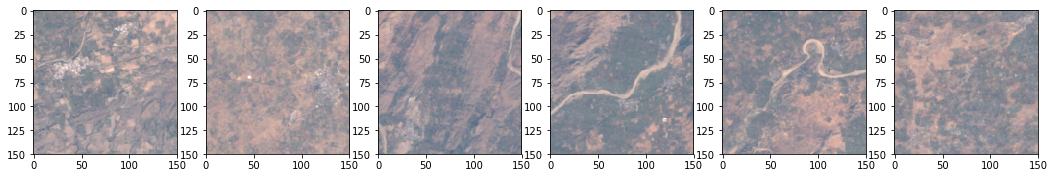

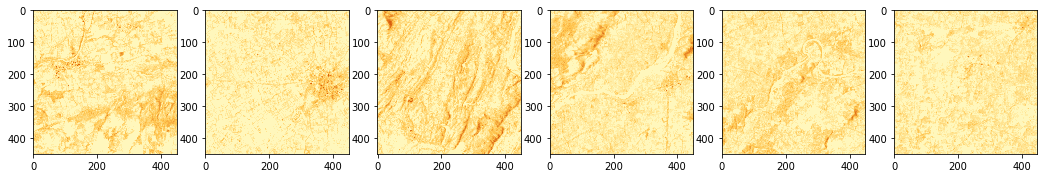

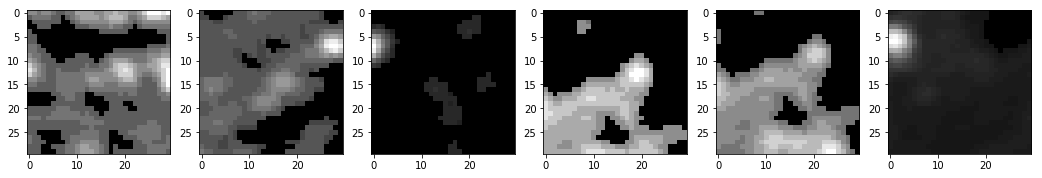

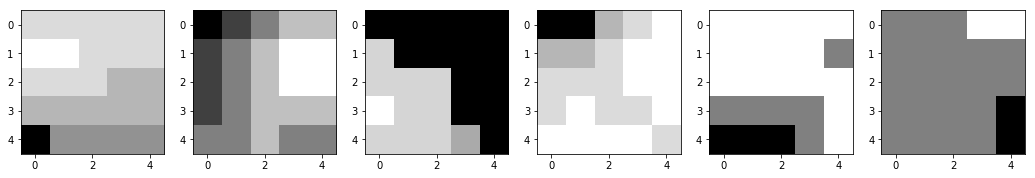

In [17]:
print("============== Class 8 ===============")
show_training_images(8, train_per_class, "L")
show_training_images(8, train_per_class, "S")
show_training_images(8, train_per_class, "N")

============== Class 9 ===============


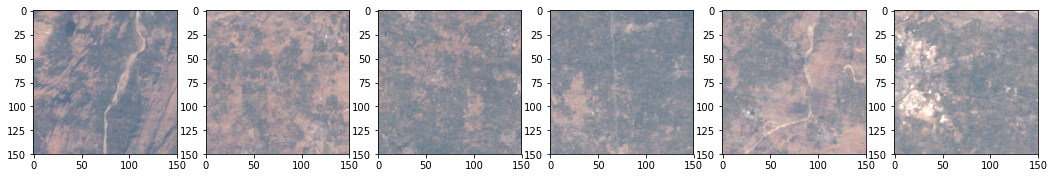

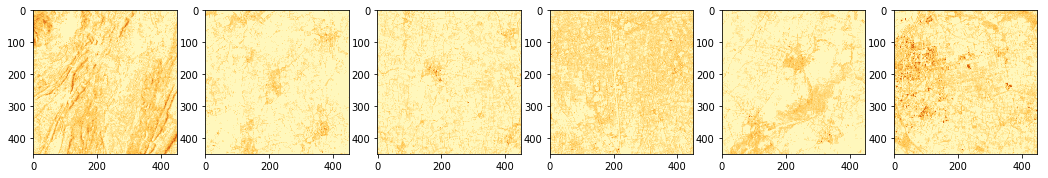

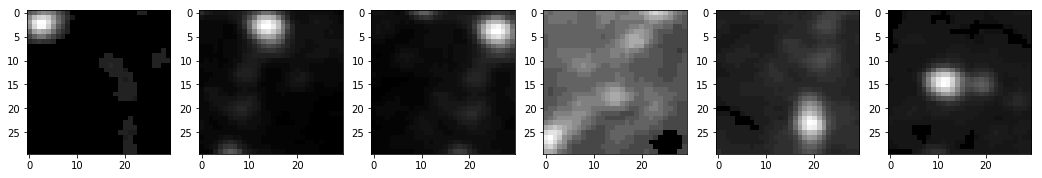

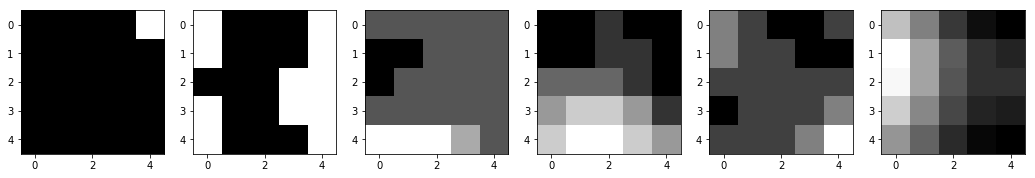

In [18]:
print("============== Class 9 ===============")
show_training_images(9, train_per_class, "L")
show_training_images(9, train_per_class, "S")
show_training_images(9, train_per_class, "N")

In [19]:
import random 

def getRandomImage():
    idx = random.randint(1,13100)
    tif_path_l = df_annos.iloc[idx].l8_vis_path
    tif_path_s = df_annos.iloc[idx].s1_vis_path
    class_label = df_annos.iloc[idx].pop_density_class
    lat = df_annos.iloc[idx].latitude
    lon = df_annos.iloc[idx].longitude
    landscan_data, label = load_tif_from_file("/home/timhu/all_tif/"+str(tif_path_l), 0, 150, 150)
    sentinel_data, label = load_tif_from_file("/home/timhu/all_tif/"+str(tif_path_s), 0, 450, 450)
    
    km_side = 5
    col, row = image_composite.geoprops.lonlat2colrow(lon, lat)
    x_5 = image_composite.gdal_dataset.ReadAsArray(col - int(km_side/2), row - int(km_side/2), km_side, km_side)
    np.place(x_5, x_5 == -2147483647, 0)
    km_side = 30
    x_30 = image_composite.gdal_dataset.ReadAsArray(col - int(km_side/2), row - int(km_side/2), km_side, km_side)
    np.place(x_30, x_30 == -2147483647, 0)
    return (class_label, [landscan_data, sentinel_data, x_30, x_5])


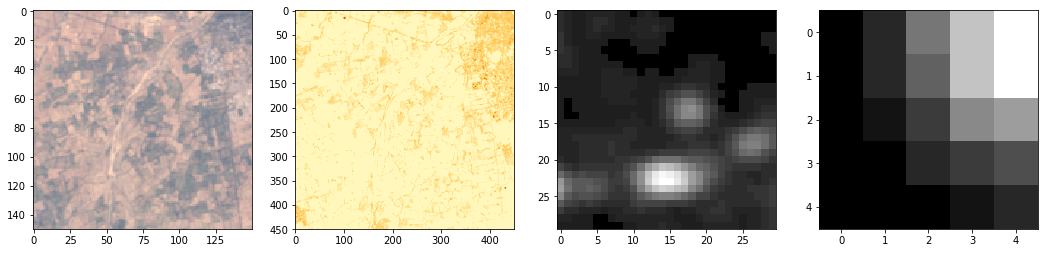

KeyboardInterrupt: 

In [20]:
class_human = []
class_census = []
#TODO: update to show all three 

for elem in range(num_validation_images):
    (true_class, img_data) = getRandomImage()
    img1 = img_data[0]
    img2 = img_data[1]
    img3 = img_data[2]
    img4 = img_data[3]
    
    cols = 4
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, cols, 0+1)
    ax1.imshow(img1)
    ax1 = fig.add_subplot(1, cols, 1+1)
    ax1.imshow(img2)
    ax1 = fig.add_subplot(1, cols, 2+1)
    ax1.imshow(img3, cmap='gray')    
    ax1 = fig.add_subplot(1, cols, 3+1)
    ax1.imshow(img4, cmap='gray')
    plt.show()
        
    x = input()
    while(not x.isdigit()):
        x = input()
    pred_class = int(x)
    print("True Class: ", true_class)
    class_human.append(pred_class)
    class_census.append(true_class)
    

In [ ]:
print(class_census)
print(class_human)

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = class_census
y_pred = class_human
cm = confusion_matrix(y_true, y_pred)

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=range(3,10),
                      title='Confusion matrix')
# Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cm, classes=range(3,10), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
# The multiclass accuracy 
print("Accuracy: %.2f"
      % np.sqrt(accuracy_score(class_census, class_human)))
# The mean squared error
print("Root mean squared error: %.2f"
      % np.sqrt(mean_squared_error(class_census, class_human)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(class_census, class_human))